In [1]:
import json
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Load data
df = pd.read_csv("modeling_dataframe.csv")  # or however you load it
df.drop(columns=['air_yards_for_model','yards_after_catch','yards_after_catch_missing'], inplace=True)

y_col = "success_outcome"
X_cols = [c for c in df.columns if c != y_col]
X_all, y_all = df[X_cols], df[y_col]

# Load params
with open("rf_best_params_v4.json") as f:
    rf_params = json.load(f)
with open("gb_best_params_v4.json") as f:
    gb_params = json.load(f)

# Recreate tuned models
best_rf = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestRegressor(**rf_params, n_jobs=-1, random_state=42)
)
best_gb = HistGradientBoostingRegressor(**gb_params, random_state=42)

# Fit on full data
best_rf.fit(X_all, y_all)
best_gb.fit(X_all, y_all)

print("Models reloaded and refit. Ready for SHAP or evaluation.")

Models reloaded and refit. Ready for SHAP or evaluation.


/Users/johnburzawa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 55453/55454 [4021:50<00:04]          


[RF] Top 20 by mean |SHAP|:
 drive_play_index                 0.040038
route_GO                         0.010519
was_pressure                     0.009974
route_POST                       0.007239
route_CORNER                     0.006702
tod_unix                         0.006678
defense_coverage_type_COVER_0    0.005473
pass_location_middle             0.005080
pass_rate_so_far                 0.004496
time_to_throw                    0.004107
defenders_in_box                 0.003961
first_down_rush_so_far           0.003921
completion_rate_so_far           0.003388
game_seconds_remaining           0.002563
first_down_pass_so_far           0.002509
offense_drive_number             0.002137
route_IN/DIG                     0.002012
tod_sin_time                     0.001968
offense_formation_SHOTGUN        0.001845
score_differential               0.001838
dtype: float64


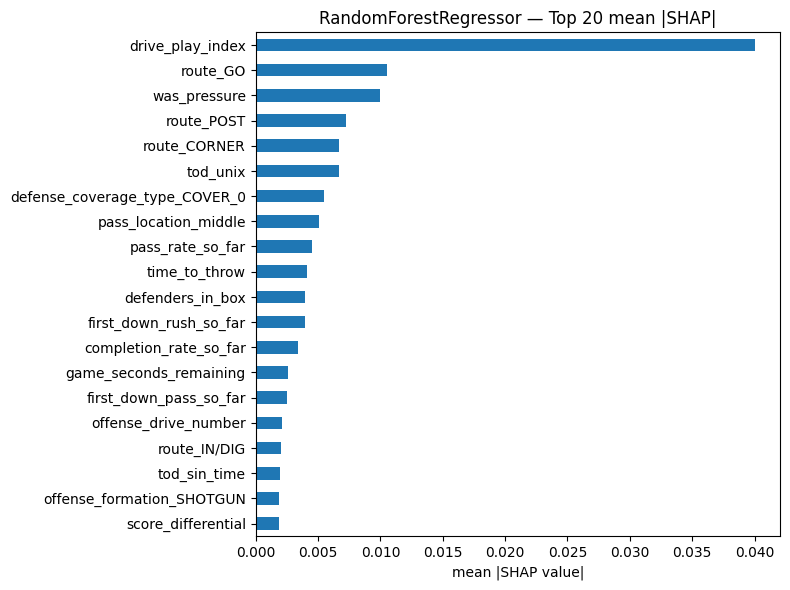

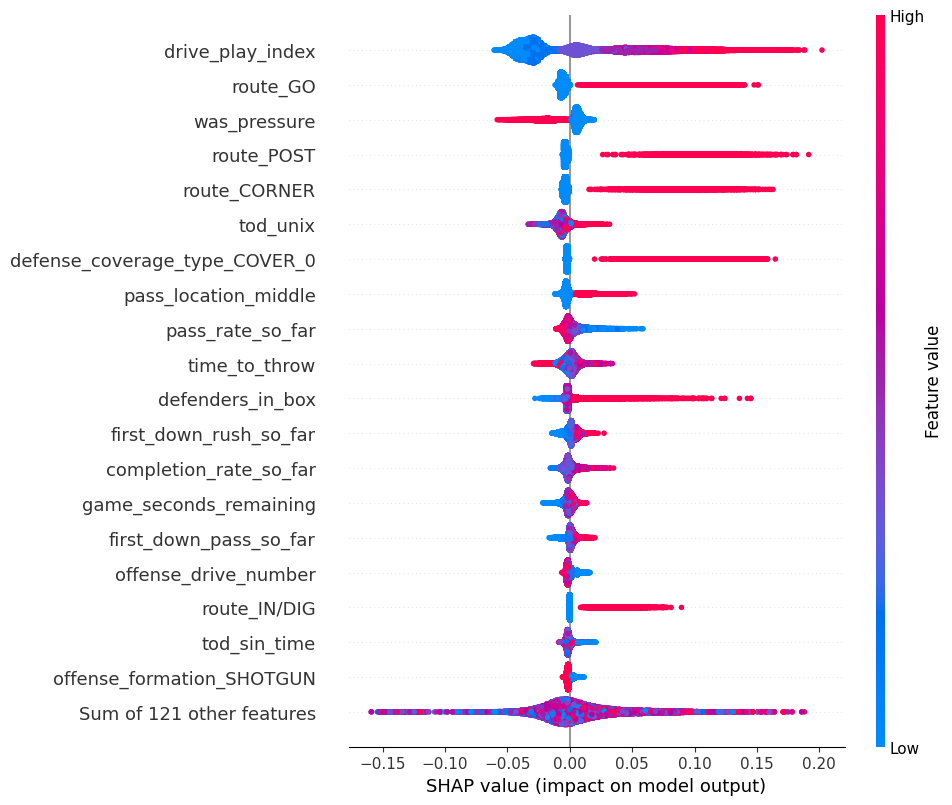

100%|===================| 55403/55454 [02:14<00:00]        


[HistGB] Top 20 by mean |SHAP|:
 drive_play_index                 0.044151
was_pressure                     0.013115
route_GO                         0.010553
route_POST                       0.009903
defense_coverage_type_COVER_0    0.009483
defenders_in_box                 0.007287
pass_rate_so_far                 0.006088
pass_location_middle             0.006081
time_to_throw                    0.005286
route_CORNER                     0.005058
first_down_rush_so_far           0.004201
route_CROSS                      0.003461
route_SLANT                      0.003209
first_down_penalty_so_far        0.003098
game_seconds_remaining           0.003002
tod_unix                         0.002768
first_down_pass_so_far           0.002764
route_IN/DIG                     0.002603
offense_formation_SHOTGUN        0.002568
third_down_failed_so_far         0.002289
dtype: float64


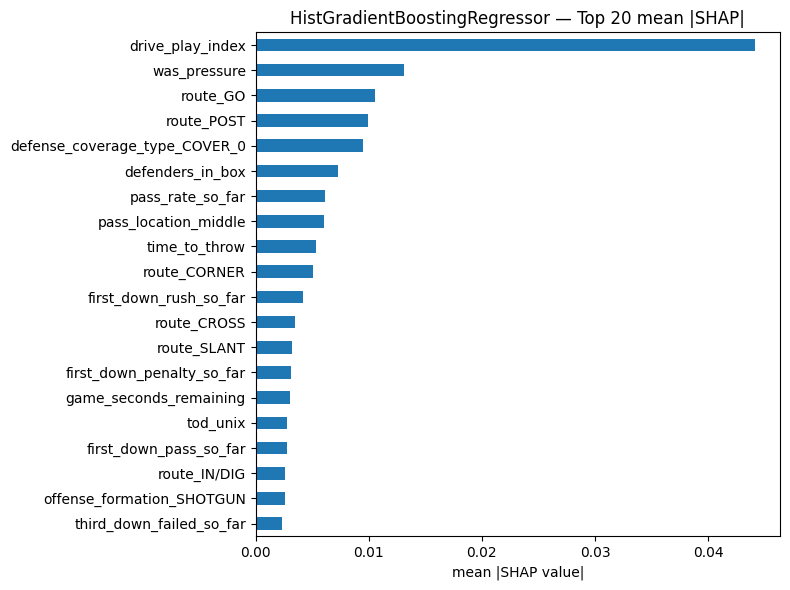

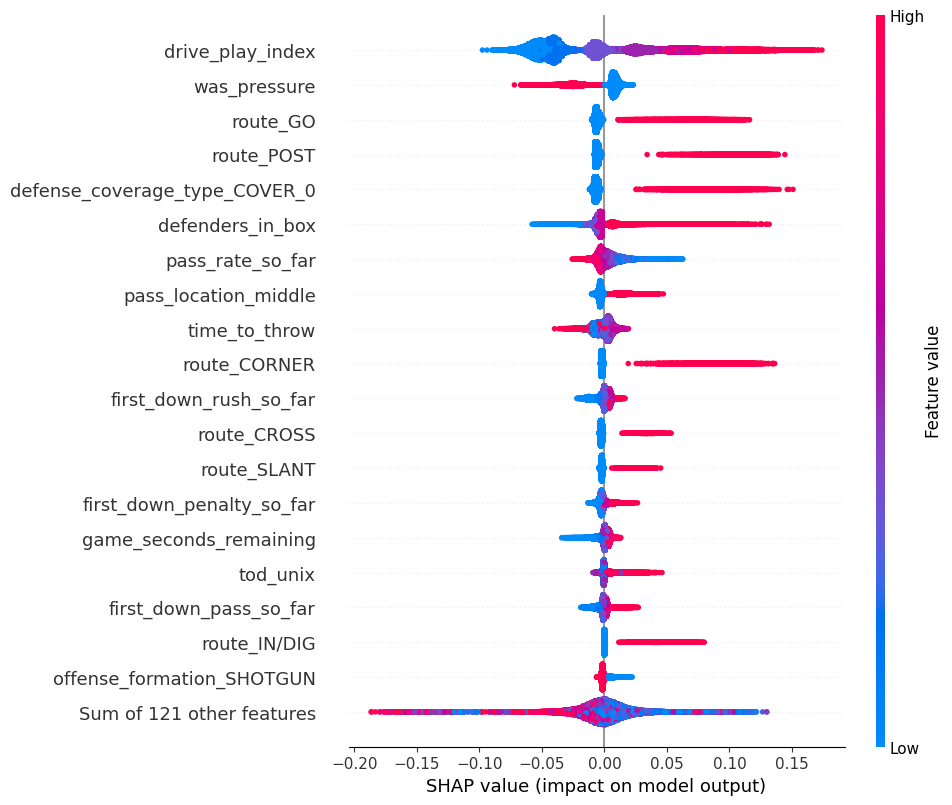

Saved: rf_shap_importance_v4.csv, histgb_shap_importance_v4.csv


In [2]:
# ===== SHAP (robust) for RF (pipeline) and HistGB =====
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# --------------------
# 0) Setup & feature names
# --------------------
feature_names = X_all.columns.tolist()

# --------------------
# 1) RandomForestRegressor (pipeline: SimpleImputer -> RF)
# --------------------
# Grab steps safely
rf_imputer = None
rf_model = None
for name, step in best_rf.named_steps.items():
    if isinstance(step, SimpleImputer):
        rf_imputer = step
    if isinstance(step, RandomForestRegressor):
        rf_model = step
assert rf_imputer is not None and rf_model is not None, "Could not find SimpleImputer/RF in best_rf pipeline."

# Transform X (exactly like training)
X_rf = rf_imputer.transform(X_all).astype("float64")  # <- RF got imputed float64 array

# Small, representative background for the masker (no legacy DenseData)
bg_rf = X_rf[: min(256, len(X_rf))]
masker_rf = shap.maskers.Independent(bg_rf)

# Force tree algorithm; disable additivity check (tiny numeric diffs are common)
rf_explainer = shap.Explainer(rf_model, masker_rf, algorithm="tree")
rf_exp = rf_explainer(X_rf, check_additivity=False)
rf_values = rf_exp.values  # (n_samples, n_features)

# Global importance
rf_importance = np.abs(rf_values).mean(axis=0)
rf_importance_s = pd.Series(rf_importance, index=feature_names).sort_values(ascending=False)
print("\n[RF] Top 20 by mean |SHAP|:\n", rf_importance_s.head(20))

# Plot
plt.figure(figsize=(8,6))
rf_importance_s.head(20)[::-1].plot(kind='barh')
plt.title("RandomForestRegressor — Top 20 mean |SHAP|")
plt.xlabel("mean |SHAP value|")
plt.tight_layout()
plt.show()

# Beeswarm (optional)
try:
    shap.plots.beeswarm(
        shap.Explanation(
            values=rf_values,
            base_values=getattr(rf_exp, "base_values", None),
            data=X_rf,
            feature_names=feature_names
        ),
        max_display=20, show=True
    )
except Exception as e:
    print(f"[RF] Beeswarm skipped: {e}")

# --------------------
# 2) HistGradientBoostingRegressor
# --------------------
# IMPORTANT: Feed the explainer the same *raw* feature shape/dtypes HGB saw.
# HGB was fit on X_all directly (no imputer), so use float64 DataFrame/array.
X_gb_np = X_all.astype("float64").values  # preserve shape & NaNs as seen in training

# Background for masker
bg_gb = X_gb_np[: min(1000, len(X_gb_np))]
masker_gb = shap.maskers.Independent(bg_gb)

# Generic explainer with tree backend; disable additivity
gb_explainer = shap.Explainer(best_gb, masker_gb, algorithm="tree")
gb_exp = gb_explainer(X_gb_np, check_additivity=False)
gb_values = gb_exp.values  # (n_samples, n_features)

# If your environment still trips, uncomment this bulletproof (but slower) fallback:
# from shap.explainers import Permutation
# gb_perm = Permutation(best_gb.predict, masker_gb)
# gb_exp = gb_perm(X_gb_np)  # check_additivity not enforced
# gb_values = gb_exp.values

# Global importance
gb_importance = np.abs(gb_values).mean(axis=0)
gb_importance_s = pd.Series(gb_importance, index=feature_names).sort_values(ascending=False)
print("\n[HistGB] Top 20 by mean |SHAP|:\n", gb_importance_s.head(20))

# Plot
plt.figure(figsize=(8,6))
gb_importance_s.head(20)[::-1].plot(kind='barh')
plt.title("HistGradientBoostingRegressor — Top 20 mean |SHAP|")
plt.xlabel("mean |SHAP value|")
plt.tight_layout()
plt.show()

# Beeswarm (optional)
try:
    shap.plots.beeswarm(
        shap.Explanation(
            values=gb_values,
            base_values=getattr(gb_exp, "base_values", None),
            data=X_gb_np,
            feature_names=feature_names
        ),
        max_display=20, show=True
    )
except Exception as e:
    print(f"[HistGB] Beeswarm skipped: {e}")

# --------------------
# 3) Save importances
# --------------------
rf_importance_s.to_csv("rf_shap_importance_v4.csv")
gb_importance_s.to_csv("histgb_shap_importance_v4.csv")
print("Saved: rf_shap_importance_v4.csv, histgb_shap_importance_v4.csv")



[RandomForest (pipeline)] 5-fold CV performance
  RMSE: 0.2407
  MAE : 0.1715
  R²  : 0.1042

[HistGradientBoosting] 5-fold CV performance
  RMSE: 0.2395
  MAE : 0.1693
  R²  : 0.1129


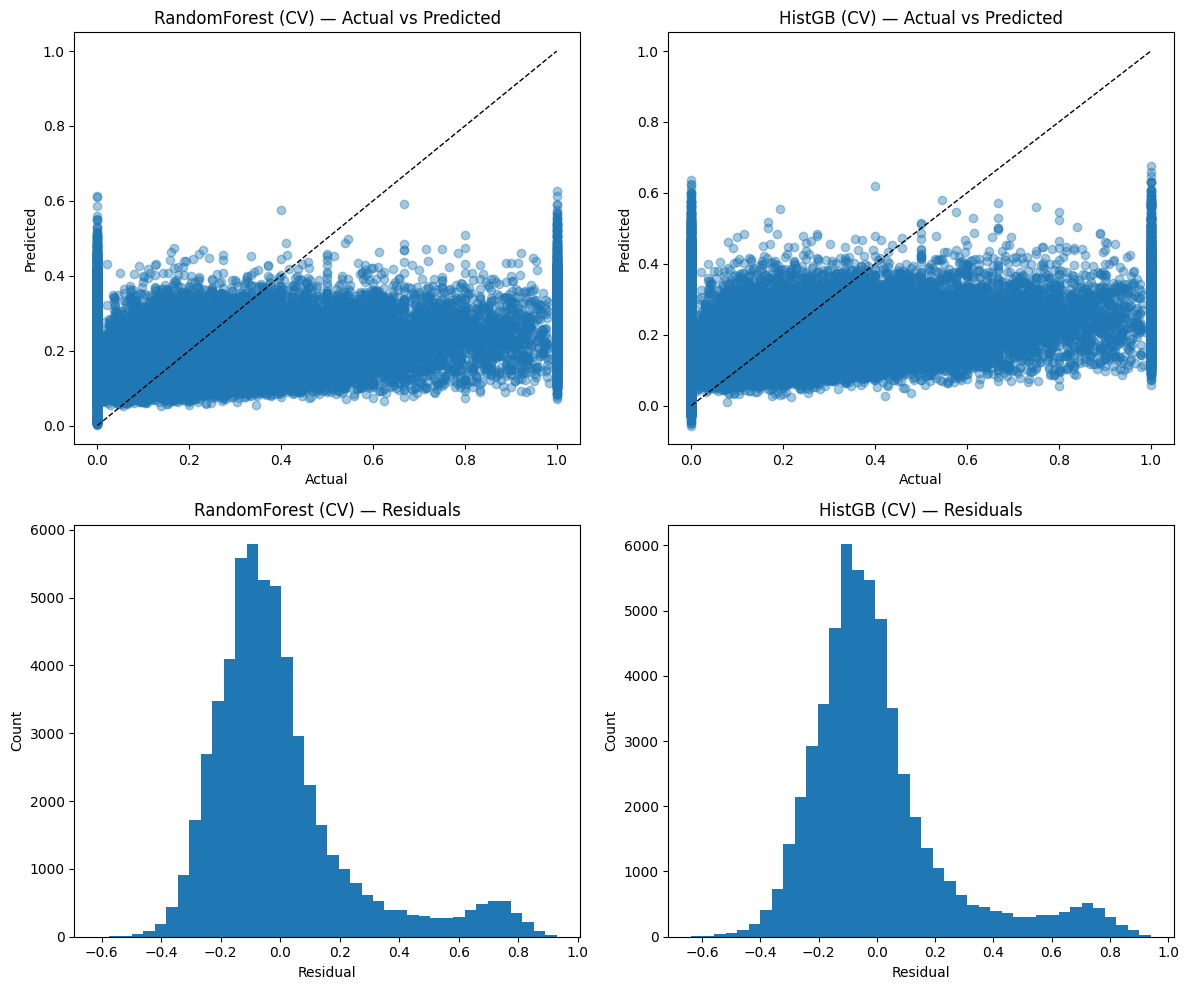

In [3]:
# ===== Cell 1: Cross-validation diagnostics for best_rf (pipeline) & best_gb =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Set up CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 2) Cross-validated predictions
# best_rf is a Pipeline (imputer -> RF), so we can pass it directly
rf_cv_pred = cross_val_predict(best_rf, X_all, y_all, cv=cv)

# best_gb is a HistGradientBoostingRegressor fit on X_all directly
gb_cv_pred = cross_val_predict(best_gb, X_all, y_all, cv=cv)

# 3) Global CV metrics
def summarize_cv(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"\n[{label}] 5-fold CV performance")
    print(f"  RMSE: {rmse:0.4f}")
    print(f"  MAE : {mae:0.4f}")
    print(f"  R²  : {r2:0.4f}")
    return rmse, mae, r2

rf_rmse, rf_mae, rf_r2 = summarize_cv(y_all, rf_cv_pred, "RandomForest (pipeline)")
gb_rmse, gb_mae, gb_r2 = summarize_cv(y_all, gb_cv_pred, "HistGradientBoosting")

# 4) Diagnostics plots: predicted vs actual & residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- RF: y vs ŷ ---
axes[0, 0].scatter(y_all, rf_cv_pred, alpha=0.4)
axes[0, 0].plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'k--', linewidth=1)
axes[0, 0].set_title("RandomForest (CV) — Actual vs Predicted")
axes[0, 0].set_xlabel("Actual")
axes[0, 0].set_ylabel("Predicted")

# --- RF: residuals ---
rf_resid = y_all - rf_cv_pred
axes[1, 0].hist(rf_resid, bins=40)
axes[1, 0].set_title("RandomForest (CV) — Residuals")
axes[1, 0].set_xlabel("Residual")
axes[1, 0].set_ylabel("Count")

# --- HGB: y vs ŷ ---
axes[0, 1].scatter(y_all, gb_cv_pred, alpha=0.4)
axes[0, 1].plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'k--', linewidth=1)
axes[0, 1].set_title("HistGB (CV) — Actual vs Predicted")
axes[0, 1].set_xlabel("Actual")
axes[0, 1].set_ylabel("Predicted")

# --- HGB: residuals ---
gb_resid = y_all - gb_cv_pred
axes[1, 1].hist(gb_resid, bins=40)
axes[1, 1].set_title("HistGB (CV) — Residuals")
axes[1, 1].set_xlabel("Residual")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()



RandomForest — CV performance by season:


,RMSE,MAE
group,,
2022,0.239103,0.170640
2023,0.238406,0.168671
2024,0.244553,0.175193



HistGradientBoosting — CV performance by season:


,RMSE,MAE
group,,
2022,0.238107,0.168434
2023,0.237212,0.166797
2024,0.243235,0.172850


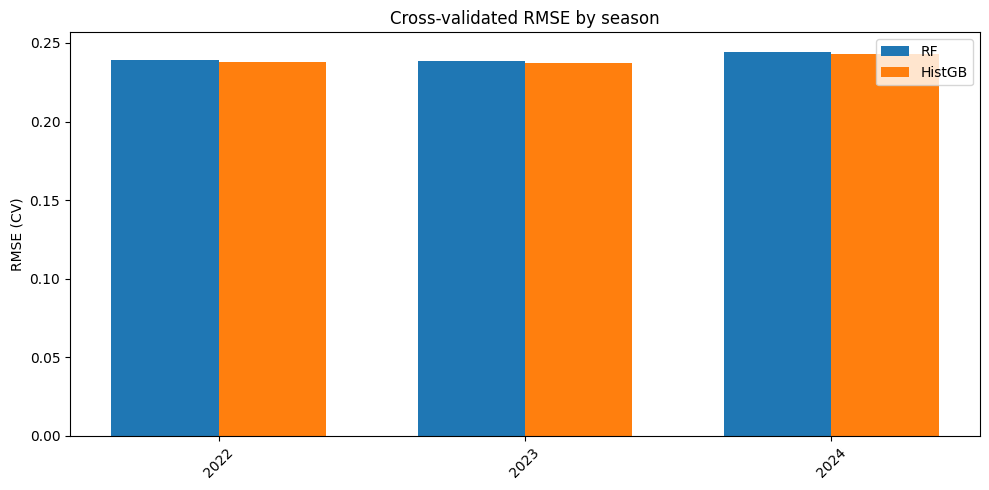

In [4]:
# ===== Cell 2: Does performance vary by season? (using CV predictions) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume 'season' is a column in X_all
seasons = X_all["season"]

# Sanity check alignment
assert len(seasons) == len(y_all) == len(rf_cv_pred) == len(gb_cv_pred)

# Helper to compute group metrics
def group_metrics(y_true, y_pred, groups):
    records = []
    for g in sorted(pd.unique(groups)):
        mask = (groups == g)
        if mask.sum() == 0:
            continue
        y_g = y_true[mask]
        yhat_g = y_pred[mask]
        rmse = np.sqrt(mean_squared_error(y_g, yhat_g))
        mae  = mean_absolute_error(y_g, yhat_g)
        records.append({"group": g, "RMSE": rmse, "MAE": mae})
    return pd.DataFrame(records).set_index("group")

rf_season_perf = group_metrics(y_all.values, rf_cv_pred, seasons.values)
gb_season_perf = group_metrics(y_all.values, gb_cv_pred, seasons.values)

print("\nRandomForest — CV performance by season:")
display(rf_season_perf.sort_index())

print("\nHistGradientBoosting — CV performance by season:")
display(gb_season_perf.sort_index())

# Plot RMSE by season for both models
fig, ax = plt.subplots(figsize=(10, 5))

# Ensure same order of seasons for both
common_seasons = sorted(set(rf_season_perf.index) & set(gb_season_perf.index))
x = np.arange(len(common_seasons))

width = 0.35
ax.bar(x - width/2, rf_season_perf.loc[common_seasons, "RMSE"], width, label="RF")
ax.bar(x + width/2, gb_season_perf.loc[common_seasons, "RMSE"], width, label="HistGB")

ax.set_xticks(x)
ax.set_xticklabels(common_seasons, rotation=45)
ax.set_ylabel("RMSE (CV)")
ax.set_title("Cross-validated RMSE by season")
ax.legend()
plt.tight_layout()
plt.show()


In [5]:
# ===== Cell 3: Does performance vary by posteam? (using CV predictions) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume 'posteam' is a column in X_all
teams = X_all["posteam"]

# Sanity check alignment
assert len(teams) == len(y_all) == len(rf_cv_pred) == len(gb_cv_pred)

def group_metrics(y_true, y_pred, groups):
    records = []
    for g in sorted(pd.unique(groups)):
        mask = (groups == g)
        if mask.sum() == 0:
            continue
        y_g = y_true[mask]
        yhat_g = y_pred[mask]
        rmse = np.sqrt(mean_squared_error(y_g, yhat_g))
        mae  = mean_absolute_error(y_g, yhat_g)
        records.append({"group": g, "RMSE": rmse, "MAE": mae, "n": mask.sum()})
    return pd.DataFrame(records).set_index("group")

rf_team_perf = group_metrics(y_all.values, rf_cv_pred, teams.values)
gb_team_perf = group_metrics(y_all.values, gb_cv_pred, teams.values)

print("\nRandomForest — CV performance by posteam:")
display(rf_team_perf.sort_values("RMSE", ascending=False).head(15))

print("\nHistGradientBoosting — CV performance by posteam:")
display(gb_team_perf.sort_values("RMSE", ascending=False).head(15))

# Plot: top 10 worst (highest RMSE) teams for each model
top_n = 10
rf_worst = rf_team_perf.sort_values("RMSE", ascending=False).head(top_n)
gb_worst = gb_team_perf.sort_values("RMSE", ascending=False).head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(rf_worst.index[::-1], rf_worst["RMSE"][::-1])
axes[0].set_title(f"RandomForest — worst {top_n} teams (CV RMSE)")
axes[0].set_xlabel("RMSE")

axes[1].barh(gb_worst.index[::-1], gb_worst["RMSE"][::-1])
axes[1].set_title(f"HistGB — worst {top_n} teams (CV RMSE)")
axes[1].set_xlabel("RMSE")

plt.tight_layout()
plt.show()


KeyError: 'posteam'

In [ ]:
# ===== Cell 4: Are SHAP value patterns consistent across teams & seasons? =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------
# Helper: compute mean |SHAP| by group (team or season)
# -------------------------------------------------------
def compute_group_shap(abs_shap, groups, feature_names):
    df = pd.DataFrame(abs_shap, columns=feature_names)
    df["group"] = groups.values
    return df.groupby("group").mean()   # mean |SHAP| for each feature

# Absolute SHAP arrays
rf_abs = np.abs(rf_values)
gb_abs = np.abs(gb_values)

teams  = X_all["posteam"]
seasons = X_all["season"]

# -------------------------------------------------------
# 1) RF: mean |SHAP| by team and by season
# -------------------------------------------------------
rf_team_shap   = compute_group_shap(rf_abs, teams, feature_names)
rf_season_shap = compute_group_shap(rf_abs, seasons, feature_names)

# -------------------------------------------------------
# 2) GB: mean |SHAP| by team and by season
# -------------------------------------------------------
gb_team_shap   = compute_group_shap(gb_abs, teams, feature_names)
gb_season_shap = compute_group_shap(gb_abs, seasons, feature_names)

# -------------------------------------------------------
# 3) Feature variability diagnostic (variances across teams/seasons)
# -------------------------------------------------------
rf_team_var   = rf_team_shap.var().sort_values(ascending=False)
rf_season_var = rf_season_shap.var().sort_values(ascending=False)

gb_team_var   = gb_team_shap.var().sort_values(ascending=False)
gb_season_var = gb_season_shap.var().sort_values(ascending=False)

print("\nTop 15 most variable RF features across teams:")
display(rf_team_var.head(15))

print("\nTop 15 most variable RF features across seasons:")
display(rf_season_var.head(15))

print("\nTop 15 most variable GB features across teams:")
display(gb_team_var.head(15))

print("\nTop 15 most variable GB features across seasons:")
display(gb_season_var.head(15))

# -------------------------------------------------------
# 4) Heatmaps (optional): visualize which features differ the most by group
# -------------------------------------------------------

# Choose top-k varying features for cleaner heatmaps
top_k = 15
rf_team_top_features = rf_team_var.head(top_k).index
rf_season_top_features = rf_season_var.head(top_k).index

gb_team_top_features = gb_team_var.head(top_k).index
gb_season_top_features = gb_season_var.head(top_k).index

# Plot heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(rf_team_shap[rf_team_top_features], cmap="viridis")
plt.title("RandomForest — mean |SHAP| by team (top varying features)")
plt.xlabel("Features")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(rf_season_shap[rf_season_top_features], cmap="viridis")
plt.title("RandomForest — mean |SHAP| by season (top varying features)")
plt.xlabel("Features")
plt.ylabel("Season")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(gb_team_shap[gb_team_top_features], cmap="viridis")
plt.title("HistGB — mean |SHAP| by team (top varying features)")
plt.xlabel("Features")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(gb_season_shap[gb_season_top_features], cmap="viridis")
plt.title("HistGB — mean |SHAP| by season (top varying features)")
plt.xlabel("Features")
plt.ylabel("Season")
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 5) Optionally save results
# -------------------------------------------------------
rf_team_shap.to_csv("rf_shap_mean_by_team.csv")
rf_season_shap.to_csv("rf_shap_mean_by_season.csv")
gb_team_shap.to_csv("gb_shap_mean_by_team.csv")
gb_season_shap.to_csv("gb_shap_mean_by_season.csv")

print("\nSaved: rf_shap_mean_by_team.csv, rf_shap_mean_by_season.csv, gb_shap_mean_by_team.csv, gb_shap_mean_by_season.csv")
